In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import sys

def load_jsd(filename) :
    y = []
    x = []
    with open(filename) as file :
        for line in file :
            x.append(float(line.split(" ")[0]))
            y.append(float(line.split(" ")[1]))
    return x,y

In [3]:
def plot_map(files, pos=0):
    fig1, ax1 = plt.subplots()
    plt.xlim(0,600)
    plt.ylim(0,600)
    if (not (type(files) is list)):
        files=[files]
    pointx=[]
    pointy=[]
    for rf in files:
        f=open(rf)
        for l in f.readlines():
            l=l.rstrip()
            lc=list(map(float, l.split(" ")))
            pointx.append(lc[0+pos])
            pointy.append(600-lc[1+pos])
        f.close()
    print("nb points: "+str(len(pointx))+" min=(%.2f, %.2f)"%(min(pointx),min(pointy))+" max=(%.2f,%.2f)"%(max(pointx),max(pointy)))
    ax1.plot(pointx,pointy,'.')
    plt.show()
def plot_map_from(folder_name,id1,id2) :
    files = []
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "maze" :
            continue
        if folder.split('_')[id1] == id2 :
            files.append(folder_name + '/' + folder + '/bd_010000.log')
    plot_map(files,3)

In [4]:
import numpy as np

def median_perc(data) : 
    median = np.zeros(data.shape[1]) 
    perc_25 = np.zeros(data.shape[1]) 
    perc_75 = np.zeros(data.shape[1]) 
    for i in range(0, len(median)): 
        median[i] = np.median(data[:, i]) 
        perc_25[i] = np.percentile(data[:, i], 25) 
        perc_75[i] = np.percentile(data[:, i], 75) 
    return median, perc_75, perc_25


In [5]:
import os

def load_test(folder_name,id1,id2,nb_rep) :
    i = 0
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "maze" :
            continue
        if folder.split('_')[id1] == id2 :
            print(folder)
            x,y = load_jsd(folder_name + folder + "/JSD.dat")
            print(len(y))
            i += 1

def load_from(folder_name,id1,id2,nb_rep,nb_gen) :
    data = np.zeros((nb_rep,nb_gen))
    i = 0
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "maze" :
            continue
        if folder.split('_')[id1] == id2 :
            #print(folder)
            x,y = load_jsd(folder_name + folder + "/JSD.dat")
            data[i, :] = y[:nb_gen]
            i += 1
    median, perc_75, perc_25 = median_perc(data)
    x = x[:nb_gen]
    return x, median, perc_75, perc_25

def plot_data_from(folder_name,id1,id2,nb_rep,nb_gen,name,ax1) :
    x, median, perc_75, perc_25 = load_from(folder_name,id1,id2,nb_rep,nb_gen)
    ax1.plot(x,median,linewidth=2,label=name)
    ax1.fill_between(x,perc_75,median,alpha=.2)
    ax1.fill_between(x,perc_25,median,alpha=.2)
    

def plot_all_data_from(folder_name,id1,nb_rep,nb_gen,r,ax1) :
    medians = []
    percs_25 = []
    percs_75 = []
    names = []
    for k in range(r[0],r[1]) :
        if(k == 0) :
            x, median, perc_75, perc_25 = load_from(folder_name,id1,'0',nb_rep,nb_gen)
            medians.append(median)
            percs_25.append(perc_25)
            percs_75.append(perc_75)
            if id1 == 4 :
                names.append("ff_0")
            if id1 == 5 :
                names.append("rec_0")
        else :
            x, median, perc_75, perc_25 = load_from(folder_name,id1,str(2**k),nb_rep,nb_gen)
            medians.append(median)
            percs_25.append(perc_25)
            percs_75.append(perc_75)
            if id1 == 4 :
                names.append("ff_" + str(2**k))
            if id1 == 5 :
                names.append("rec_" + str(2**k))

    i = 0
    for m in medians :
        ax1.plot(x,m,linewidth=2,label=names[i])
        ax1.fill_between(x,percs_75[i],m,alpha=.2)
        ax1.fill_between(x,percs_25[i],m,alpha=.2)
        i += 1


In [6]:
def load_dnn_data(file_name) :
    with open(file_name) as f :
        gen = int(file_name.split('_')[-1].split('.')[0])
        neurons_dat = [int(n) for n in f.readline().split(' ')[:-1]]
        connections_dat = [int(c) for c in f.readline().split(' ')[:-1]]
    
    return gen, neurons_dat, connections_dat    

def plot_dnn_data_from(folder_name,id1,id2,nb_gen,pop_size,ax1) :
    
    neurons_data = np.zeros((1,nb_gen))
    connections_data = np.zeros((1,nb_gen))
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "maze" :
            continue
        if folder.split('_')[id1] == id2 :
            #print(folder)
            gen_vct = []
            neurons = np.zeros((pop_size,nb_gen))
            connections = np.zeros((pop_size,nb_gen))
            i = 0
            for file_name in os.listdir(folder_name + '/' + folder) :
                if file_name.split('_')[0] != "neat" :
                    continue
                gen, ndat, cdat = load_dnn_data(folder_name + '/' + folder + '/' + file_name)
                gen_vct.append(gen)
                neurons[:, i] = ndat
                connections[:, i] = cdat
                i += 1
            neurons_data = np.concatenate((neurons_data,neurons))
            connections_data = np.concatenate((connections_data,connections))

    # gen_vct, neurons_data,connections_data = \
    # zip(*sorted(zip(gen_vct,neurons_data,connections_data)))

    neurons_data = neurons_data[1:]
    connections_data = connections_data[1:]
    
    m_ndat, p75_ndat, p25_ndat = median_perc(neurons_data)
    m_cdat, p75_cdat, p25_cdat = median_perc(connections_data)

    gen_vct = np.array(gen_vct)
    sortind = gen_vct.argsort()
    gen_vct = gen_vct[sortind[::-1]]
    
    m_ndat = m_ndat[sortind[::-1]]
    p75_ndat = m_ndat[sortind[::-1]]
    p25_ndat = m_ndat[sortind[::-1]]
    
    m_cdat = m_cdat[sortind[::-1]]
    p75_cdat = m_cdat[sortind[::-1]]
    p25_cdat = m_cdat[sortind[::-1]]

    
    ax1.plot(gen_vct,m_ndat, color='b',linewidth=2,label="nb of neurons")
    ax1.fill_between(gen_vct,p75_ndat,m_ndat,color='b',alpha=.2)
    ax1.fill_between(gen_vct,p25_ndat,m_ndat,color='b',alpha=.2)
    
    ax1.plot(gen_vct,m_cdat, color='r', linewidth=2, label="nb of connections")
    ax1.fill_between(gen_vct,p75_cdat,m_cdat,color='r',alpha=.2)
    ax1.fill_between(gen_vct,p25_cdat,m_cdat,color='r',alpha=.2)
    


In [114]:
dnn_folder = "/home/leni/sferes_log/neat_all_mazes_first_run/"

*** Results for the hard maze ***


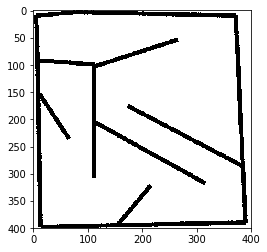

In [84]:
print("*** Results for the hard maze ***")
hard_folder = "/home/leni/sferes_log/hard_maze_first_run/"
pic = img.imread("../maze.pbm")
plt.imshow(pic)
plt.show()

Feed-forward Plot of all the occupancy score


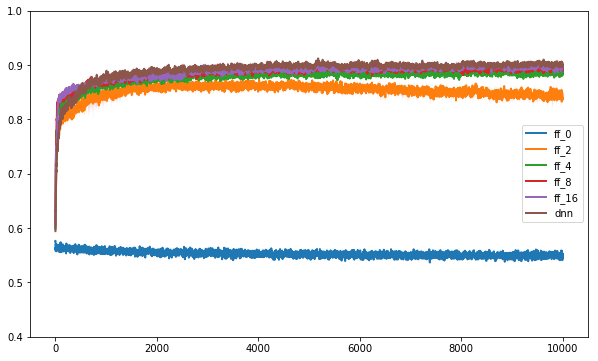

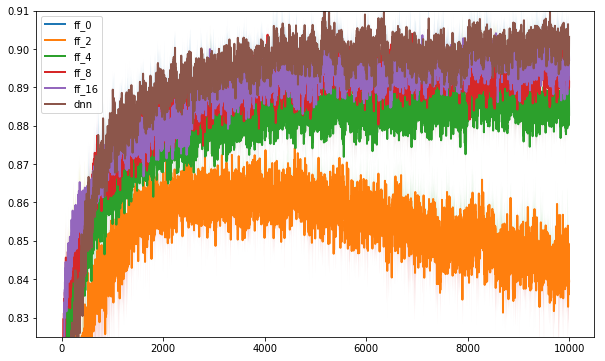

In [85]:
print("Feed-forward Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(hard_folder,4,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"2019-06-27",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.825,0.91])
plot_all_data_from(hard_folder,4,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"2019-06-27",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Recursive Plot of all the occupancy score


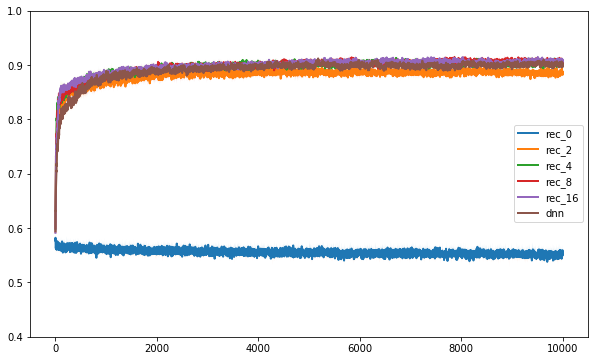

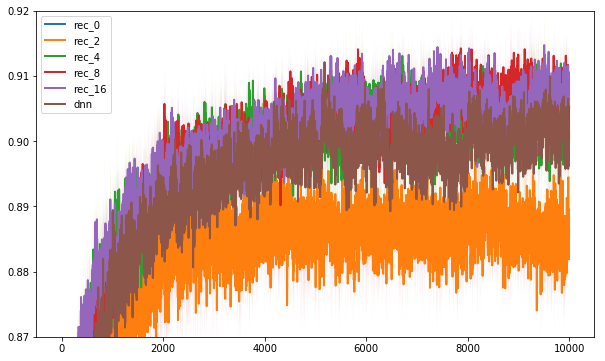

In [86]:
print("Recursive Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(hard_folder,5,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"2019-06-27",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.87,0.92])
plot_all_data_from(hard_folder,5,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"2019-06-27",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN


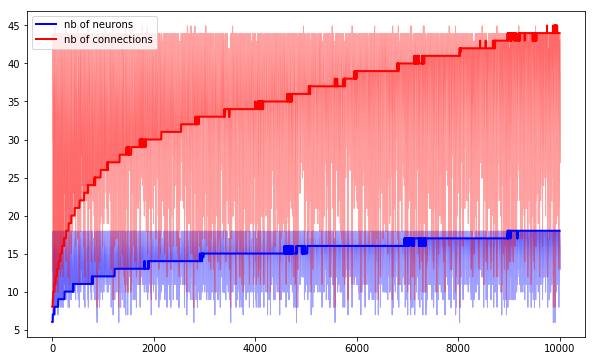

In [48]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_dnn_data_from(dnn_folder,3,"2019-06-27",10001,400,ax1)
plt.legend()
plt.show()

plot final positions in population 400 per replication over 10 replications
feed-forward no hidden layer
nb points: 4000 min=(26.25, 29.25) max=(344.89,433.34)


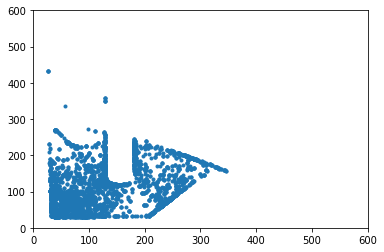

feed-forward 2 neurons hidden layer
nb points: 4000 min=(23.25, 29.26) max=(545.25,563.86)


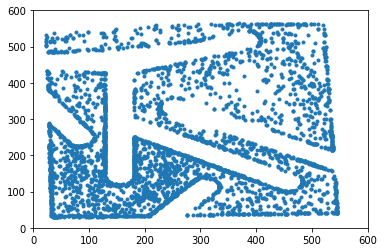

feed-forward 4 neurons hidden layer
nb points: 4000 min=(23.25, 29.26) max=(545.24,565.04)


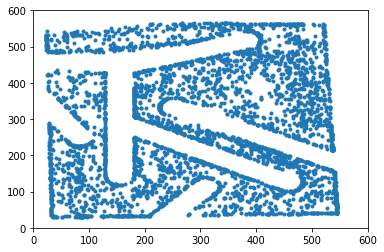

feed-forward 8 neurons hidden layer
nb points: 4000 min=(23.21, 29.25) max=(545.23,567.71)


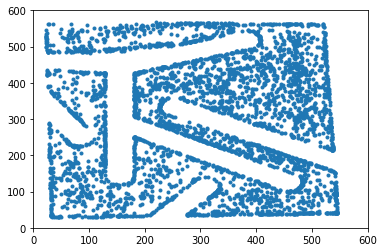

feed-forward 16 neurons hidden layer
nb points: 4000 min=(21.79, 29.46) max=(545.24,569.16)


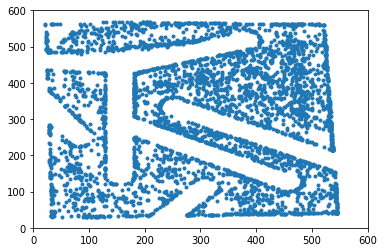

Recursive no hidden layer
nb points: 4000 min=(24.75, 29.25) max=(332.20,431.13)


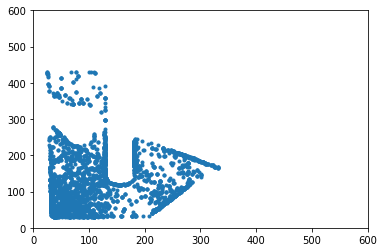

Recursive 2 neurons hidden layer
nb points: 4000 min=(21.76, 29.28) max=(545.25,569.24)


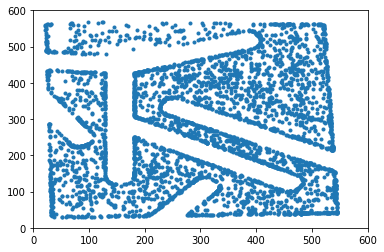

Recursive 4 neurons hidden layer
nb points: 4000 min=(21.76, 29.25) max=(545.24,569.25)


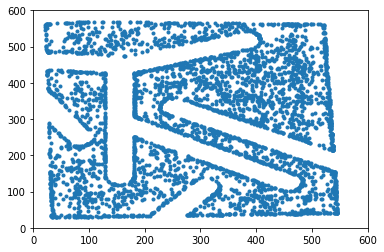

Recursive 8 neurons hidden layer
nb points: 4000 min=(22.35, 29.25) max=(545.23,569.10)


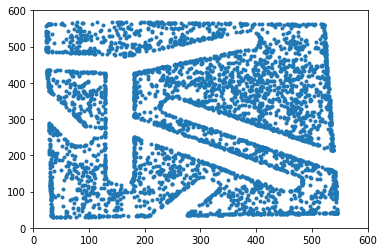

Recursive 16 neurons hidden layer
nb points: 4000 min=(21.76, 29.29) max=(545.24,569.11)


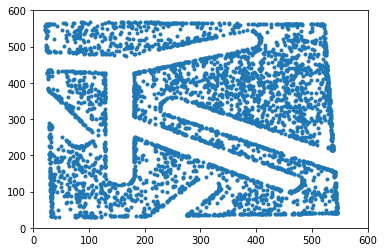

DNN
nb points: 4000 min=(21.76, 29.29) max=(545.25,569.06)


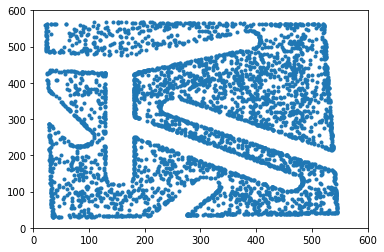

In [127]:
print("plot final positions in population 400 per replication over 10 replications")
print("feed-forward no hidden layer")
plot_map_from(hard_folder,4,'0')
print("feed-forward 2 neurons hidden layer")
plot_map_from(hard_folder,4,'2')
print("feed-forward 4 neurons hidden layer")
plot_map_from(hard_folder,4,'4')
print("feed-forward 8 neurons hidden layer")
plot_map_from(hard_folder,4,'8')
print("feed-forward 16 neurons hidden layer")
plot_map_from(hard_folder,4,'16')
print("Recursive no hidden layer")
plot_map_from(hard_folder,5,'0')
print("Recursive 2 neurons hidden layer")
plot_map_from(hard_folder,5,'2')
print("Recursive 4 neurons hidden layer")
plot_map_from(hard_folder,5,'4')
print("Recursive 8 neurons hidden layer")
plot_map_from(hard_folder,5,'8')
print("Recursive 16 neurons hidden layer")
plot_map_from(hard_folder,5,'16')
print("DNN")
plot_map_from(dnn_folder,3,'2019-06-27')

*** Results for the multi2 maze ***


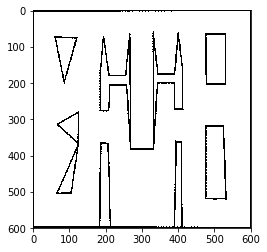

In [128]:
print("*** Results for the multi2 maze ***")
multi2_folder = "/home/leni/sferes_log/multi2_maze_first_run"
pic = img.imread("../multi2.pbm")
plt.imshow(pic)
plt.show()

Feed-forward Plot of all the occupancy score


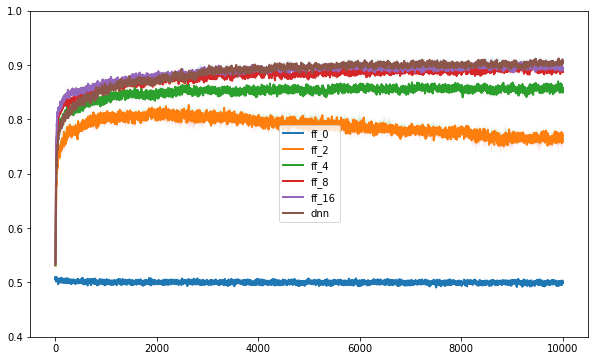

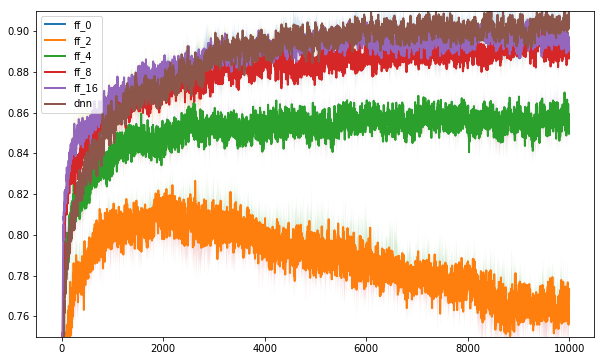

In [87]:
print("Feed-forward Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(multi2_folder,4,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"multi2",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.75,0.91])
plot_all_data_from(multi2_folder,4,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"multi2",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Recursive Plot of all the occupancy score


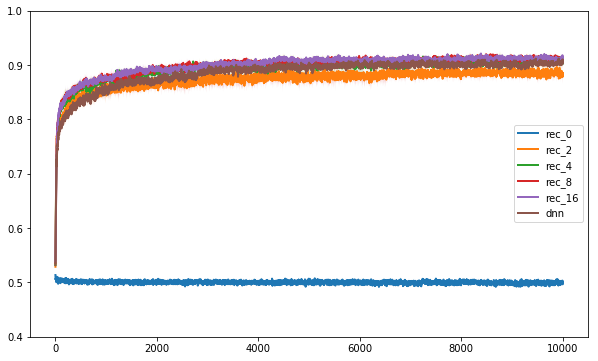

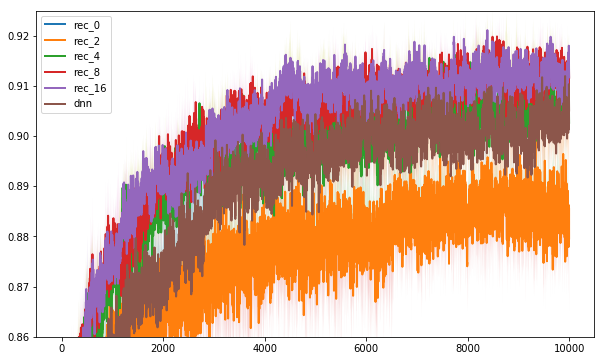

In [88]:
print("Recursive Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(multi2_folder,5,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"multi2",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.86,0.925])
plot_all_data_from(multi2_folder,5,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"multi2",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN


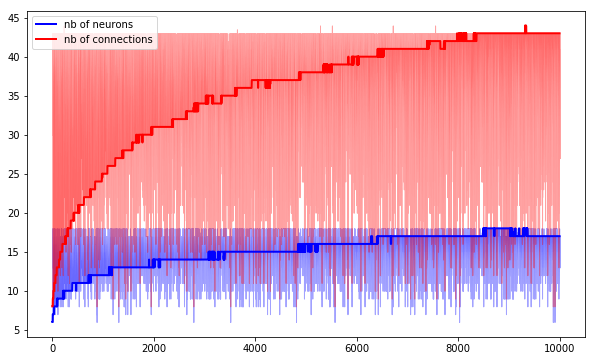

In [38]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_dnn_data_from(dnn_folder,3,"multi2",10001,400,ax1)
plt.legend()
plt.show()

plot final positions in population 400 per replication over 10 replications
feed-forward no hidden layer
nb points: 4000 min=(219.56, 24.50) max=(362.50,548.15)


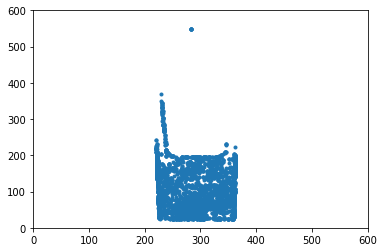

feed-forward 2 neurons hidden layer
nb points: 4000 min=(13.50, 24.50) max=(567.50,576.50)


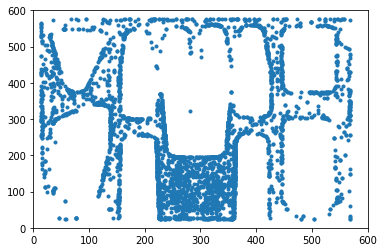

feed-forward 4 neurons hidden layer
nb points: 4000 min=(13.50, 24.50) max=(567.50,576.50)


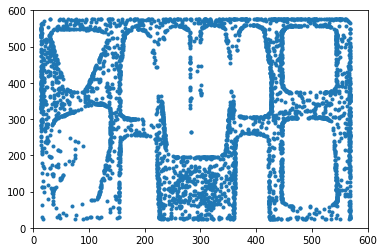

feed-forward 8 neurons hidden layer
nb points: 4000 min=(13.50, 24.51) max=(567.50,576.50)


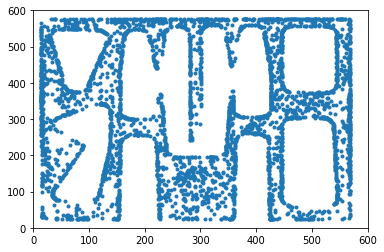

feed-forward 16 neurons hidden layer
nb points: 4000 min=(13.50, 24.50) max=(567.50,576.50)


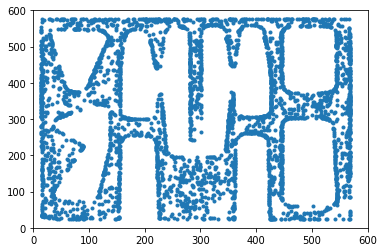

Recursive no hidden layer
nb points: 4000 min=(147.78, 24.50) max=(362.50,399.07)


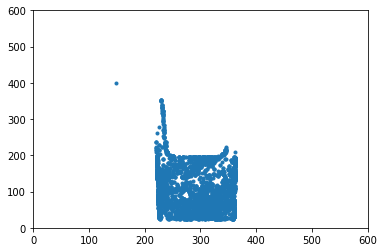

Recursive 2 neurons hidden layer
nb points: 3600 min=(13.58, 24.53) max=(567.50,576.49)


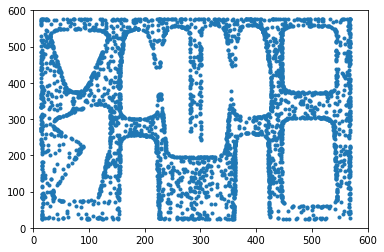

Recursive 4 neurons hidden layer
nb points: 4000 min=(13.50, 24.51) max=(567.50,576.50)


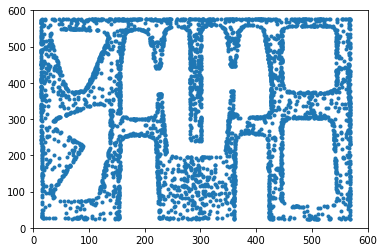

Recursive 8 neurons hidden layer
nb points: 4000 min=(13.51, 24.50) max=(567.50,576.50)


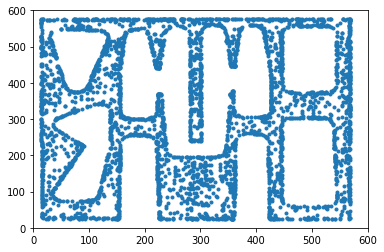

Recursive 16 neurons hidden layer
nb points: 4000 min=(13.50, 24.50) max=(567.50,576.50)


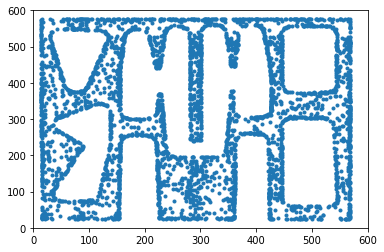

DNN
nb points: 4000 min=(13.54, 24.50) max=(567.50,576.50)


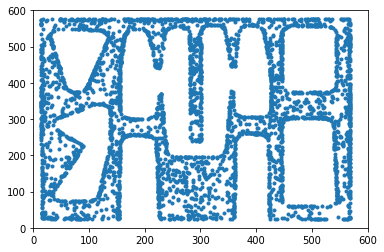

In [131]:
print("plot final positions in population 400 per replication over 10 replications")
print("feed-forward no hidden layer")
plot_map_from(multi2_folder,4,'0')
print("feed-forward 2 neurons hidden layer")
plot_map_from(multi2_folder,4,'2')
print("feed-forward 4 neurons hidden layer")
plot_map_from(multi2_folder,4,'4')
print("feed-forward 8 neurons hidden layer")
plot_map_from(multi2_folder,4,'8')
print("feed-forward 16 neurons hidden layer")
plot_map_from(multi2_folder,4,'16')
print("Recursive no hidden layer")
plot_map_from(multi2_folder,5,'0')
print("Recursive 2 neurons hidden layer")
plot_map_from(multi2_folder,5,'2')
print("Recursive 4 neurons hidden layer")
plot_map_from(multi2_folder,5,'4')
print("Recursive 8 neurons hidden layer")
plot_map_from(multi2_folder,5,'8')
print("Recursive 16 neurons hidden layer")
plot_map_from(multi2_folder,5,'16')
print("DNN")
plot_map_from(dnn_folder,3,'multi2')

*** Results for the subset2 maze ***


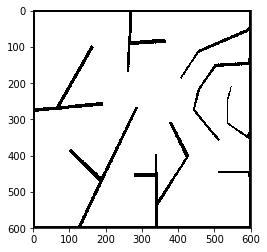

In [93]:
print("*** Results for the subset2 maze ***")
subset2_folder = "/home/leni/sferes_log/subset2_maze_first_run/"
pic = img.imread("../subset2.pbm")
plt.imshow(pic)
plt.show()

Feed-forward Plot of all the occupancy score


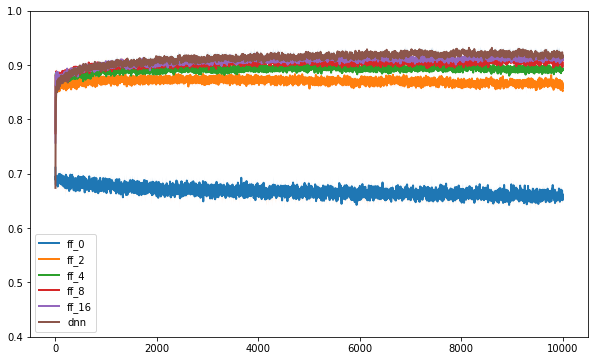

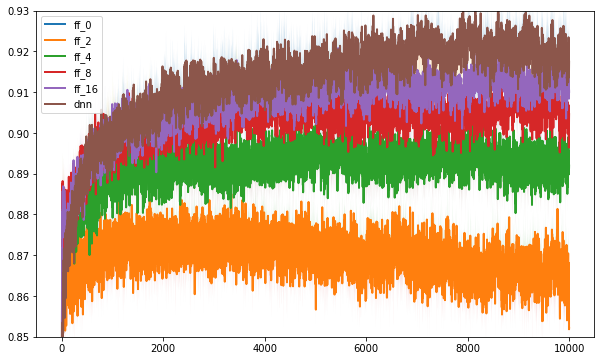

In [94]:
print("Feed-forward Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(subset2_folder,4,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"subset",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.85,0.93])
plot_all_data_from(subset2_folder,4,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"subset",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Recursive Plot of all the occupancy score


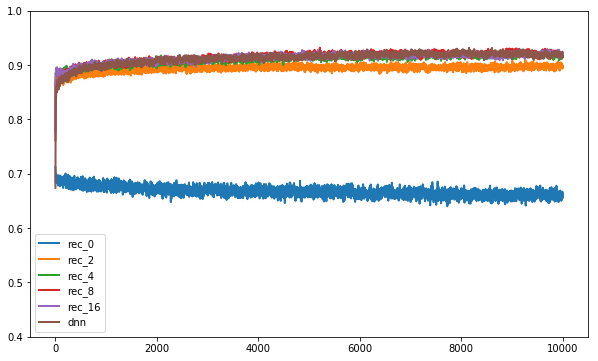

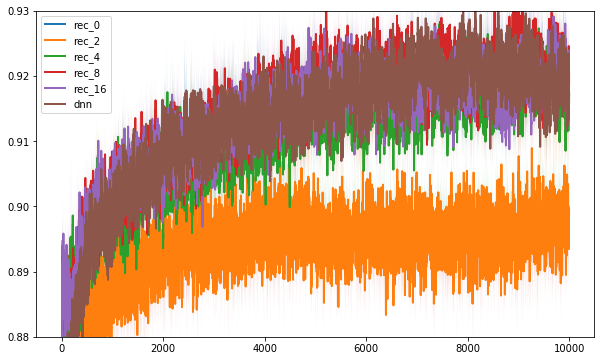

In [95]:
print("Recursive Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(subset2_folder,5,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"subset",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.88,0.93])
plot_all_data_from(subset2_folder,5,10,10001,[0,5],ax1)
plot_data_from(dnn_folder,3,"subset",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN


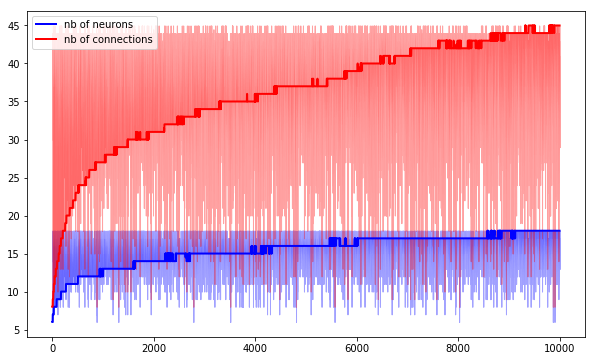

In [69]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_dnn_data_from(dnn_folder,3,"subset",10001,400,ax1)
plt.legend()
plt.show()

plot final positions in population 400 per replication over 10 replications
feed-forward no hidden layer
nb points: 4000 min=(17.50, 26.51) max=(565.50,574.50)


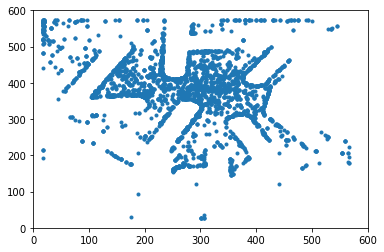

feed-forward 2 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.49,574.50)


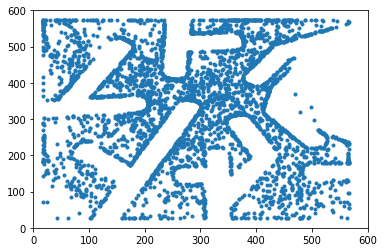

feed-forward 4 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


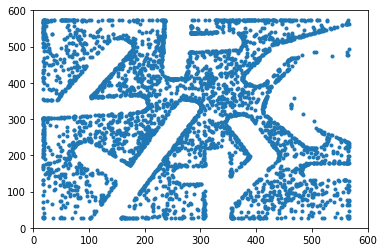

feed-forward 8 neurons hidden layer
nb points: 4000 min=(17.50, 26.51) max=(565.49,574.50)


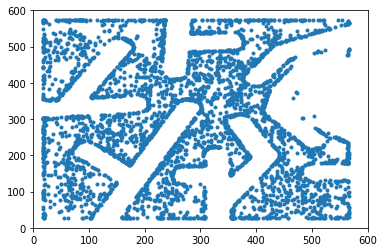

feed-forward 16 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


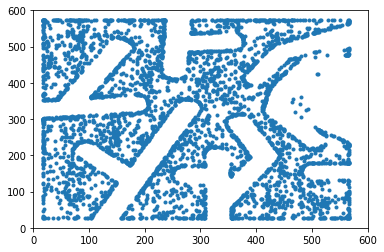

Recursive no hidden layer
nb points: 4000 min=(17.50, 26.51) max=(565.50,574.50)


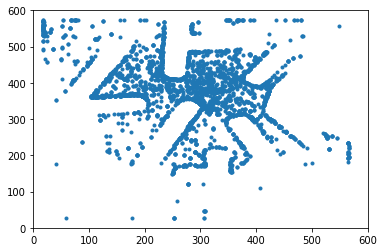

Recursive 2 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


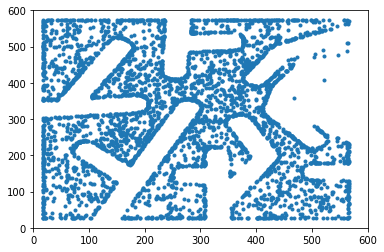

Recursive 4 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


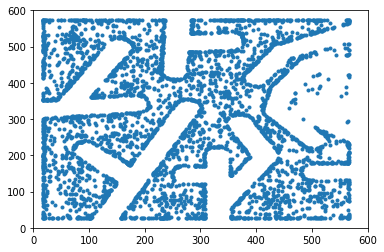

Recursive 8 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


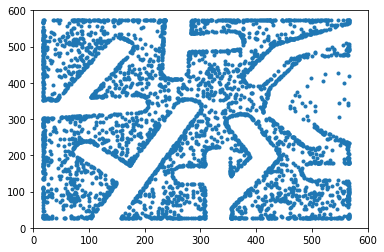

Recursive 16 neurons hidden layer
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


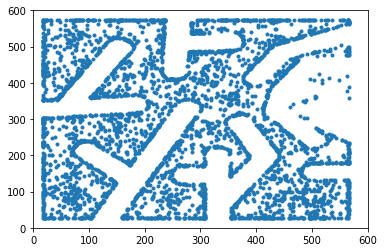

DNN
nb points: 4000 min=(17.50, 26.50) max=(565.50,574.50)


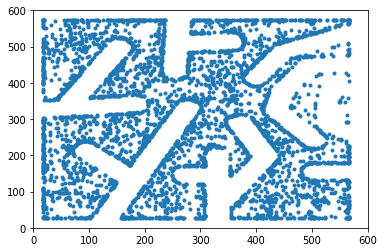

In [126]:
print("plot final positions in population 400 per replication over 10 replications")
print("feed-forward no hidden layer")
plot_map_from(subset2_folder,4,'0')
print("feed-forward 2 neurons hidden layer")
plot_map_from(subset2_folder,4,'2')
print("feed-forward 4 neurons hidden layer")
plot_map_from(subset2_folder,4,'4')
print("feed-forward 8 neurons hidden layer")
plot_map_from(subset2_folder,4,'8')
print("feed-forward 16 neurons hidden layer")
plot_map_from(subset2_folder,4,'16')
print("Recursive no hidden layer")
plot_map_from(subset2_folder,5,'0')
print("Recursive 2 neurons hidden layer")
plot_map_from(subset2_folder,5,'2')
print("Recursive 4 neurons hidden layer")
plot_map_from(subset2_folder,5,'4')
print("Recursive 8 neurons hidden layer")
plot_map_from(subset2_folder,5,'8')
print("Recursive 16 neurons hidden layer")
plot_map_from(subset2_folder,5,'16')
print("DNN")
plot_map_from(dnn_folder,3,'subset')

*** Results for the multi maze ***


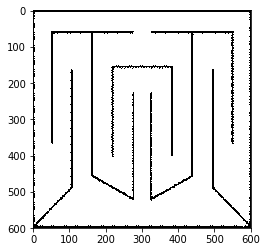

In [72]:
print("*** Results for the multi maze ***")
multi_folder = "/home/leni/sferes_log/multi_maze_first_run/"
pic = img.imread("../multi.pbm")
plt.imshow(pic)
plt.show()

Feed-forward Plot of all the occupancy score


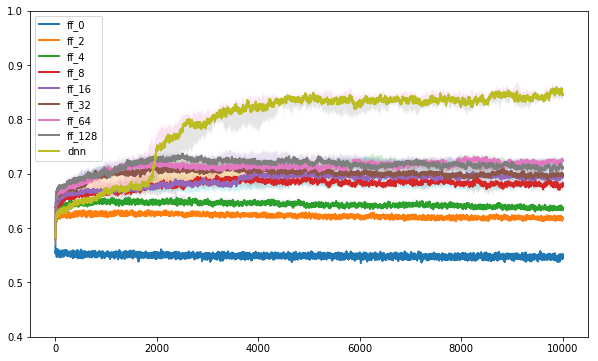

In [133]:
print("Feed-forward Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(multi_folder,4,10,10001,[0,8],ax1)
plot_data_from(dnn_folder,3,"multi",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Recursive Plot of all the occupancy score


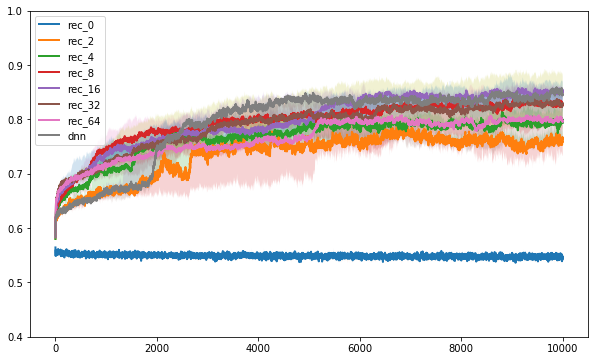

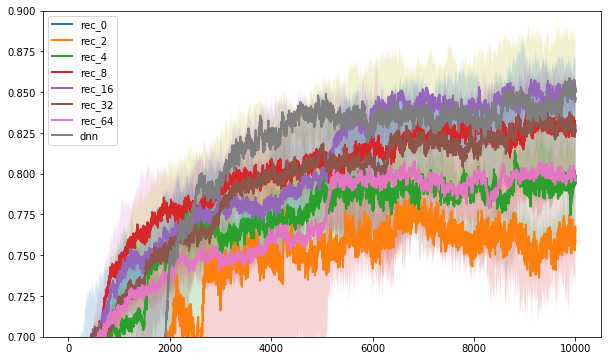

In [134]:
print("Recursive Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_all_data_from(multi_folder,5,10,10001,[0,7],ax1)
plot_data_from(dnn_folder,3,"multi",10,10001,"dnn",ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.7,0.9])
plot_all_data_from(multi_folder,5,10,10001,[0,7],ax1)
plot_data_from(dnn_folder,3,"multi",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN


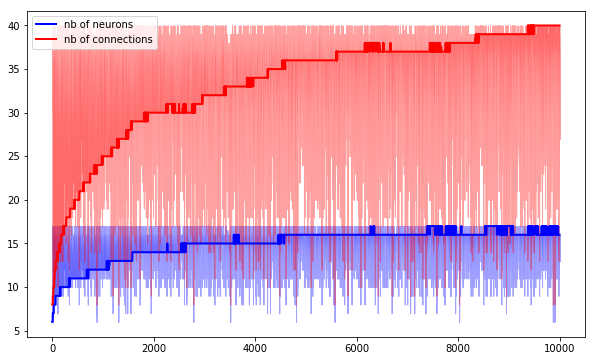

In [96]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_dnn_data_from(dnn_folder,3,"multi",10001,400,ax1)
plt.legend()
plt.show()

plot final positions in population 400 per replication over 10 replications
feed-forward no hidden layer
nb points: 4000 min=(52.31, 26.50) max=(534.67,279.56)


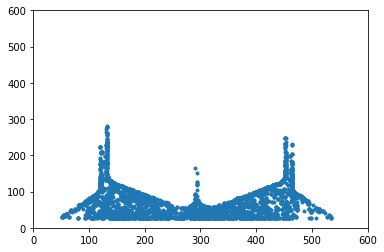

feed-forward 2 neurons hidden layer
nb points: 4000 min=(49.32, 26.50) max=(533.74,499.46)


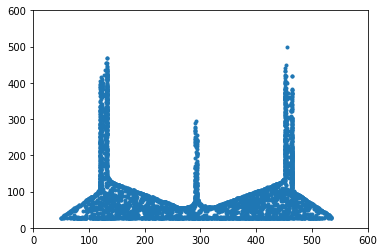

feed-forward 4 neurons hidden layer
nb points: 4000 min=(49.24, 26.50) max=(566.36,516.47)


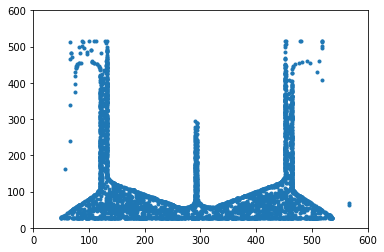

feed-forward 8 neurons hidden layer
nb points: 4000 min=(16.81, 26.50) max=(566.50,516.50)


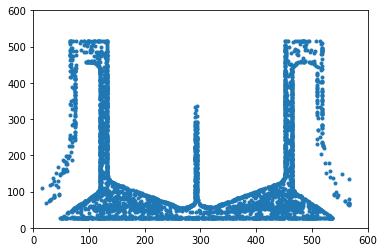

feed-forward 16 neurons hidden layer
nb points: 4000 min=(16.51, 26.50) max=(566.49,516.50)


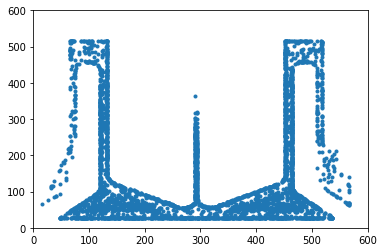

feed-forward 32 neurons hidden layer
nb points: 4000 min=(16.66, 26.50) max=(566.50,516.50)


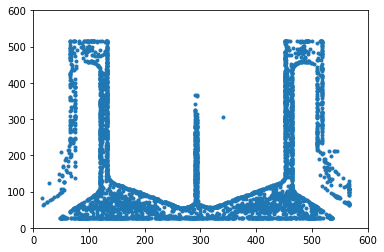

feed-forward 64 neurons hidden layer
nb points: 4000 min=(16.56, 26.50) max=(566.50,516.50)


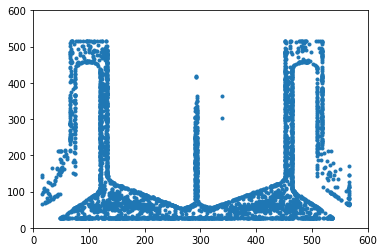

feed-forward 128 neurons hidden layer
nb points: 4000 min=(16.52, 26.50) max=(566.50,516.50)


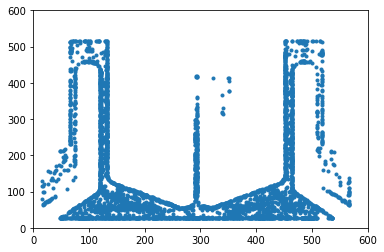

Recursive no hidden layer
nb points: 4000 min=(52.61, 26.50) max=(534.98,281.44)


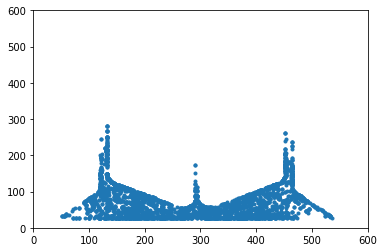

Recursive 2 neurons hidden layer
nb points: 4000 min=(16.50, 26.50) max=(566.50,574.29)


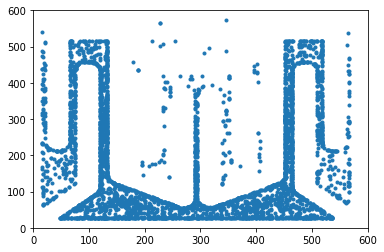

Recursive 4 neurons hidden layer
nb points: 4000 min=(16.50, 26.50) max=(566.50,575.40)


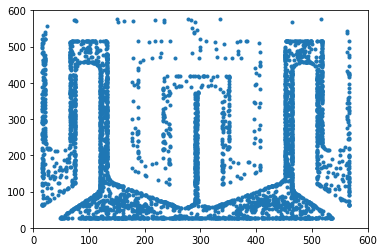

Recursive 8 neurons hidden layer
nb points: 4000 min=(16.50, 26.50) max=(566.50,574.98)


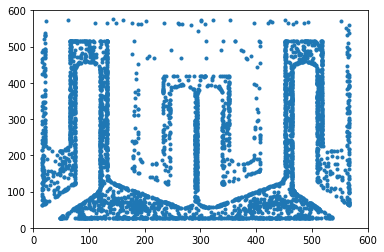

Recursive 16 neurons hidden layer
nb points: 4000 min=(16.50, 26.50) max=(566.50,575.37)


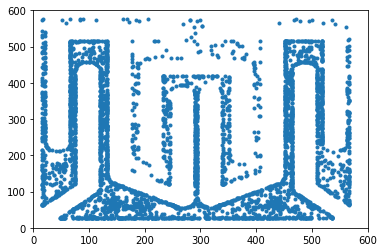

Recursive 32 neurons hidden layer
nb points: 4000 min=(16.50, 26.50) max=(566.50,574.94)


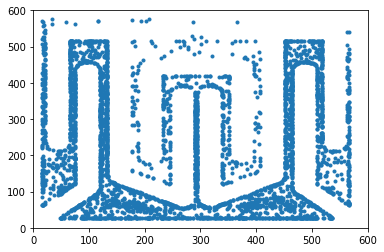

Recursive 64 neurons hidden layer
nb points: 4000 min=(16.50, 26.50) max=(566.49,537.87)


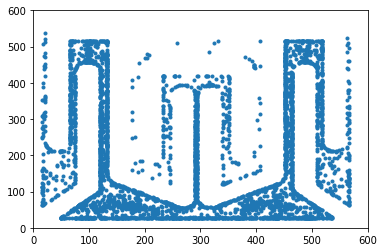

DNN
nb points: 4000 min=(16.50, 26.50) max=(566.50,575.47)


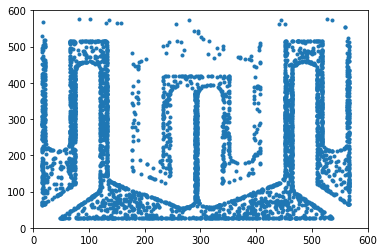

In [136]:
print("plot final positions in population 400 per replication over 10 replications")
print("feed-forward no hidden layer")
plot_map_from(multi_folder,4,'0')
print("feed-forward 2 neurons hidden layer")
plot_map_from(multi_folder,4,'2')
print("feed-forward 4 neurons hidden layer")
plot_map_from(multi_folder,4,'4')
print("feed-forward 8 neurons hidden layer")
plot_map_from(multi_folder,4,'8')
print("feed-forward 16 neurons hidden layer")
plot_map_from(multi_folder,4,'16')
print("feed-forward 32 neurons hidden layer")
plot_map_from(multi_folder,4,'32')
print("feed-forward 64 neurons hidden layer")
plot_map_from(multi_folder,4,'64')
print("feed-forward 128 neurons hidden layer")
plot_map_from(multi_folder,4,'128')
print("Recursive no hidden layer")
plot_map_from(multi_folder,5,'0')
print("Recursive 2 neurons hidden layer")
plot_map_from(multi_folder,5,'2')
print("Recursive 4 neurons hidden layer")
plot_map_from(multi_folder,5,'4')
print("Recursive 8 neurons hidden layer")
plot_map_from(multi_folder,5,'8')
print("Recursive 16 neurons hidden layer")
plot_map_from(multi_folder,5,'16')
print("Recursive 32 neurons hidden layer")
plot_map_from(multi_folder,5,'32')
print("Recursive 64 neurons hidden layer")
plot_map_from(multi_folder,5,'64')
print("DNN")
plot_map_from(dnn_folder,3,'multi')

*** Results for the multi maze ***


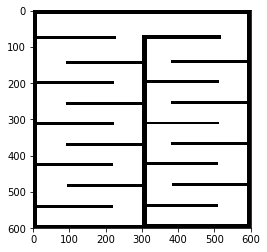

In [9]:
print("*** Results for the multi maze ***")
zigzag_folder = "/home/leni/sferes_log/zigzag_run/"
pic = img.imread("../zigzag.pbm")
plt.imshow(pic)
plt.show()

Feed-forward Plot of all the occupancy score


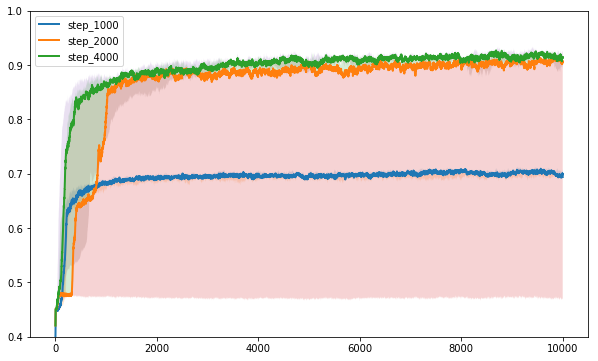

In [20]:
print("Feed-forward Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_data_from(zigzag_folder,6,'2019-07-10',10,10001,"step_1000",ax1)
plot_data_from(zigzag_folder,7,'2000',10,10001,"step_2000",ax1)
plot_data_from(zigzag_folder,7,'4000',10,10001,"step_4000",ax1)
#plot_data_from(dnn_folder,3,"zigzag",10,10001,"dnn",ax1)
plt.legend()
plt.show()

Recursive Plot of all the occupancy score


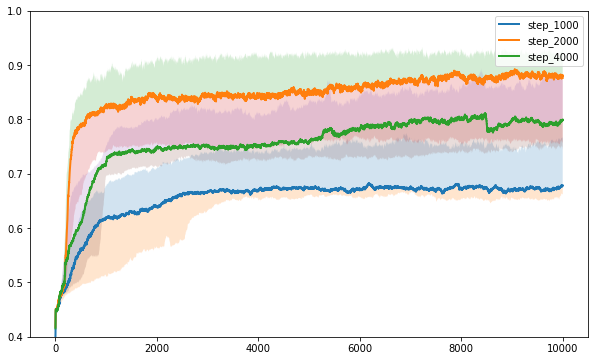

In [21]:
print("Recursive Plot of all the occupancy score")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([0.4,1.])
plot_data_from(zigzag_folder,7,'2019-07-10',10,10001,"step_1000",ax1)
plot_data_from(zigzag_folder,8,'2000',10,10001,"step_2000",ax1)
plot_data_from(zigzag_folder,8,'4000',10,10001,"step_4000",ax1)
#plot_data_from(dnn_folder,3,"zigzag",10,10001,"dnn",ax1)
plt.legend()
plt.show()

plot final positions in population 400 per replication over 10 replications
feed-forward 1000 steps
nb points: 4000 min=(23.50, 28.50) max=(272.50,523.54)


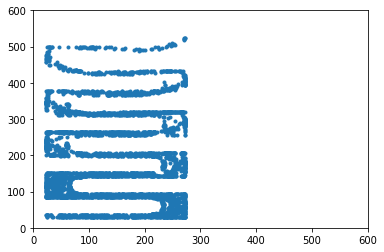

feed-forward 2000 steps
nb points: 4000 min=(23.50, 28.50) max=(561.50,569.50)


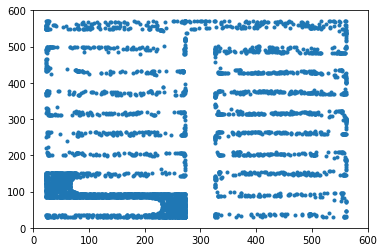

feed-forward 4000 steps
nb points: 4000 min=(23.50, 28.50) max=(561.50,569.50)


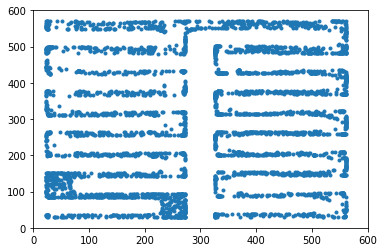

recursive 1000 steps
nb points: 4000 min=(23.50, 28.50) max=(561.44,569.50)


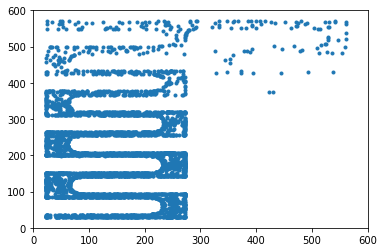

recursive 2000 steps
nb points: 4000 min=(23.50, 28.50) max=(561.49,569.50)


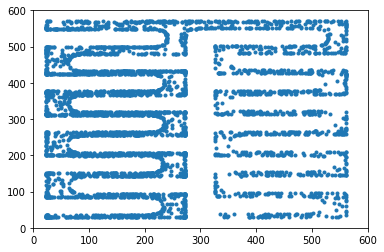

recursive 4000 steps
nb points: 4000 min=(23.50, 28.50) max=(561.49,569.50)


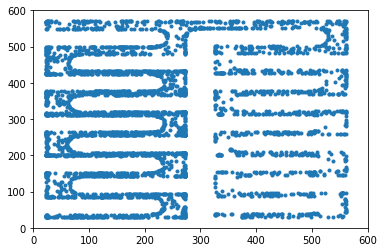

In [22]:
print("plot final positions in population 400 per replication over 10 replications")
print("feed-forward 1000 steps")
plot_map_from(zigzag_folder,6,'2019-07-10')
print("feed-forward 2000 steps")
plot_map_from(zigzag_folder,7,'2000')
print("feed-forward 4000 steps")
plot_map_from(zigzag_folder,7,'4000')
print("recursive 1000 steps")
plot_map_from(zigzag_folder,7,'2019-07-10')
print("recursive 2000 steps")
plot_map_from(zigzag_folder,8,'2000')
print("recursive 4000 steps")
plot_map_from(zigzag_folder,8,'4000')